100%|██████████| 9.91M/9.91M [00:01<00:00, 6.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.92MB/s]


Epoch 1, Loss: 94.9434, Accuracy: 0.9515
Epoch 2, Loss: 27.9003, Accuracy: 0.9856
Epoch 3, Loss: 19.7805, Accuracy: 0.9897
Epoch 4, Loss: 16.2478, Accuracy: 0.9917
Test Accuracy: 0.9910

Adversarial Image Creation Progress:
Step 1: Predicted = 4, Target = 9, Correct w.r.t True Label: True, Accuracy: 100.0%
Step 2: Predicted = 4, Target = 9, Correct w.r.t True Label: True, Accuracy: 100.0%
Step 3: Predicted = 8, Target = 9, Correct w.r.t True Label: False, Accuracy: 0.0%
Step 4: Predicted = 9, Target = 9, Correct w.r.t True Label: False, Accuracy: 0.0%
Adversarial attack succeeded at step 4.



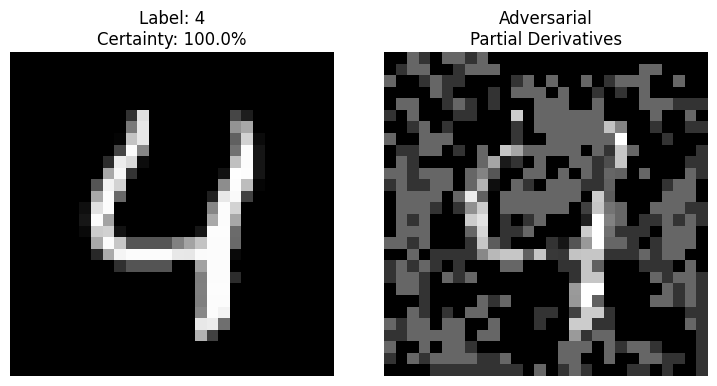

Original Image - Predicted Label: 4, True Label: 4, Accuracy: 100.0%
Adversarial Image - Predicted Label: 9, True Label: 4, Accuracy: 0.0%


In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)

X_train = train_dataset.data.view(-1, 28*28).float() / 255.0
y_train = train_dataset.targets
X_test = test_dataset.data.view(-1, 28*28).float() / 255.0
y_test = test_dataset.targets

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# CNN Model using PyTorch
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model, define loss and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {correct / len(train_dataset):.4f}")

# Evaluation on test data
model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {total_correct / len(test_dataset):.4f}")

# Helper: Get images of a specific label
def get_images_of_label(dataset, label, num_images):
    indices = (dataset.targets == label).nonzero(as_tuple=True)[0]
    selected = torch.utils.data.Subset(dataset, indices[:num_images])
    return torch.stack([x[0] for x in selected]), [x[1] for x in selected]

# Plot predictions
def plot_predictions(model, images, adversarial=False):
    model.eval()
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    certainties = torch.max(probs, dim=1).values * 100

    fig = plt.figure(1, (9., 9.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(images)), axes_pad=0.5)

    for i in range(len(images)):
        img = images[i].squeeze().detach().numpy()
        grid[i].imshow(img, cmap='gray')
        title = f"Label: {preds[i].item()}\nCertainty: {certainties[i]:.1f}%"
        if adversarial and i == 1:
            title = "Adversarial\nPartial Derivatives"
        grid[i].set_title(title)
        grid[i].axis('off')
    plt.show()

# Create adversarial example and print accuracy at each step
def create_adversarial_example(model, image, true_label, target_label, lr=0.2, max_steps=100):
    image_adv = image.clone().detach().requires_grad_(True)
    target = torch.tensor([target_label])
    step = 0

    print("\nAdversarial Image Creation Progress:")
    while step < max_steps:
        output = model(image_adv)
        pred = output.argmax(dim=1)
        is_correct = (pred.item() == true_label)

        print(f"Step {step+1}: Predicted = {pred.item()}, "
              f"Target = {target_label}, "
              f"Correct w.r.t True Label: {is_correct}, "
              f"Accuracy: {100.0 if is_correct else 0.0}%")

        if pred.item() == target_label:
            print(f"Adversarial attack succeeded at step {step+1}.\n")
            break

        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()
        image_adv.data -= lr * image_adv.grad.data.sign()
        image_adv.data.clamp_(0, 1)
        image_adv.grad.zero_()
        step += 1

    if step == max_steps:
        print(f"Warning: adversarial attack did not fully succeed after {max_steps} steps.\n")

    return image_adv.detach()

# Main run
label_of_interest = 4
images, labels = get_images_of_label(test_dataset, label_of_interest, 1)
image = images[0].unsqueeze(0)
true_label = labels[0]

# Create adversarial image targeting label 9
target_label = 9
image_adv = create_adversarial_example(model, image, true_label, target_label)

# Plot predictions
plot_predictions(model, torch.cat([image, image_adv]), adversarial=True)

# Final evaluation and print
model.eval()
with torch.no_grad():
    # Original image
    output_original = model(image)
    pred_original = output_original.argmax(dim=1)
    correct_original = (pred_original == true_label).item()

    # Adversarial image
    output_adv = model(image_adv)
    pred_adv = output_adv.argmax(dim=1)
    correct_adv = (pred_adv == true_label).item()

print(f"Original Image - Predicted Label: {pred_original.item()}, "
      f"True Label: {true_label}, "
      f"Accuracy: {correct_original * 100:.1f}%")

print(f"Adversarial Image - Predicted Label: {pred_adv.item()}, "
      f"True Label: {true_label}, "
      f"Accuracy: {correct_adv * 100:.1f}%")



The goal here is to slightly modify an input image (a digit "4") so that the CNN incorrectly classifies it as another digit ("9") — without making the image look very different to a human.
This is called creating an adversarial example.

You're using a simple version of the Fast Gradient Sign Method (FGSM) to do this.



we create an adversarial example by slightly modifying the input image so that the CNN model misclassifies it as a target label (e.g., from a 4 to a 9). First, we clone the original image, enable gradient tracking, and define the desired target label. Then, in a loop, we repeatedly compute the model's prediction on the adversarial image, print the current prediction and accuracy, and check if the attack succeeded. If not, we calculate the cross-entropy loss toward the target label, backpropagate to get the gradient, and update the image by slightly adjusting its pixels in the direction that increases the target label's probability (using the gradient sign). After each modification, we clamp the pixel values between 0 and 1 to keep the image valid. This process continues until the model predicts the target label or the maximum number of steps is reached, after which the final adversarial image is returned.

Noisy Image - Predicted Label: 4, True Label: 4, Accuracy: 100.0%


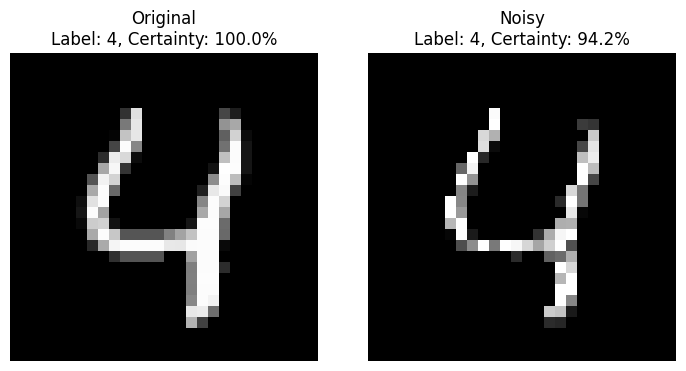

In [2]:
# --- Create a noisy version of the image ---

def create_noisy_example(image, noise_level=0.3):
    """
    Adds random noise to an image.

    Args:
        image (Tensor): Input image tensor of shape [1, 1, 28, 28].
        noise_level (float): Standard deviation of the Gaussian noise.

    Returns:
        Tensor: Noisy image tensor.
    """
    noise = torch.randn_like(image) * noise_level
    image_noisy = image + noise
    image_noisy = torch.clamp(image_noisy, 0, 1)  # Keep pixel values between 0 and 1
    return image_noisy

# --- Apply it to your MNIST test image ---

# Assume you already have 'image' and 'true_label' from previous code
# (from get_images_of_label)

# Create noisy image
noise_level = 0.3  # You can adjust this (try 0.1, 0.5, etc.)
image_noisy = create_noisy_example(image, noise_level=noise_level)

# --- Predict with model ---

model.eval()
with torch.no_grad():
    output_noisy = model(image_noisy)
    pred_noisy = output_noisy.argmax(dim=1)
    correct_noisy = (pred_noisy == true_label).item()

print(f"Noisy Image - Predicted Label: {pred_noisy.item()}, "
      f"True Label: {true_label}, "
      f"Accuracy: {correct_noisy * 100:.1f}%")

# --- Plot original and noisy images side by side ---

def plot_original_and_noisy(original_img, noisy_img, model):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.cat([original_img, noisy_img]))
        preds = outputs.argmax(dim=1)
        probs = F.softmax(outputs, dim=1)
        certainties = torch.max(probs, dim=1).values * 100

    fig = plt.figure(1, (9., 4.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.5)

    images = [original_img, noisy_img]
    titles = [
        f"Original\nLabel: {preds[0].item()}, Certainty: {certainties[0]:.1f}%",
        f"Noisy\nLabel: {preds[1].item()}, Certainty: {certainties[1]:.1f}%"
    ]

    for i in range(2):
        img = images[i].squeeze().detach().numpy()
        grid[i].imshow(img, cmap='gray')
        grid[i].set_title(titles[i])
        grid[i].axis('off')

    plt.show()

# Call the plot function
plot_original_and_noisy(image, image_noisy, model)


Noisy Image - Predicted Label: 4, True Label: 4, Accuracy: 100.0%


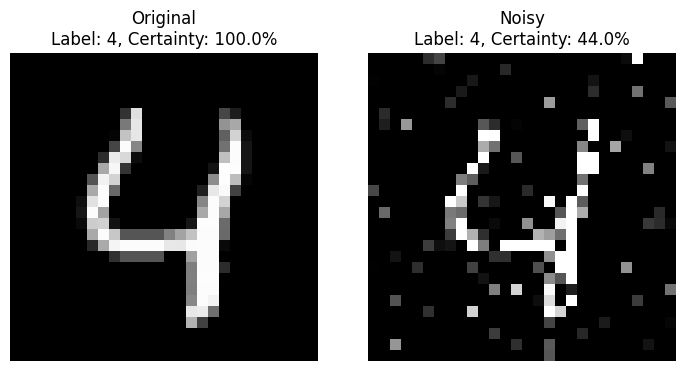

In [3]:
# --- Create a noisy version of the image ---

def create_noisy_example(image, noise_level=0.3):
    """
    Adds random noise to an image.

    Args:
        image (Tensor): Input image tensor of shape [1, 1, 28, 28].
        noise_level (float): Standard deviation of the Gaussian noise.

    Returns:
        Tensor: Noisy image tensor.
    """
    noise = torch.randn_like(image) * noise_level
    image_noisy = image + noise
    image_noisy = torch.clamp(image_noisy, 0, 1)  # Keep pixel values between 0 and 1
    return image_noisy

# --- Apply it to your MNIST test image ---

# Assume you already have 'image' and 'true_label' from previous code
# (from get_images_of_label)

# Create noisy image
noise_level = 0.7  # You can adjust this (try 0.1, 0.5, etc.)
image_noisy = create_noisy_example(image, noise_level=noise_level)

# --- Predict with model ---

model.eval()
with torch.no_grad():
    output_noisy = model(image_noisy)
    pred_noisy = output_noisy.argmax(dim=1)
    correct_noisy = (pred_noisy == true_label).item()

print(f"Noisy Image - Predicted Label: {pred_noisy.item()}, "
      f"True Label: {true_label}, "
      f"Accuracy: {correct_noisy * 100:.1f}%")

# --- Plot original and noisy images side by side ---

def plot_original_and_noisy(original_img, noisy_img, model):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.cat([original_img, noisy_img]))
        preds = outputs.argmax(dim=1)
        probs = F.softmax(outputs, dim=1)
        certainties = torch.max(probs, dim=1).values * 100

    fig = plt.figure(1, (9., 4.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.5)

    images = [original_img, noisy_img]
    titles = [
        f"Original\nLabel: {preds[0].item()}, Certainty: {certainties[0]:.1f}%",
        f"Noisy\nLabel: {preds[1].item()}, Certainty: {certainties[1]:.1f}%"
    ]

    for i in range(2):
        img = images[i].squeeze().detach().numpy()
        grid[i].imshow(img, cmap='gray')
        grid[i].set_title(titles[i])
        grid[i].axis('off')

    plt.show()

# Call the plot function
plot_original_and_noisy(image, image_noisy, model)


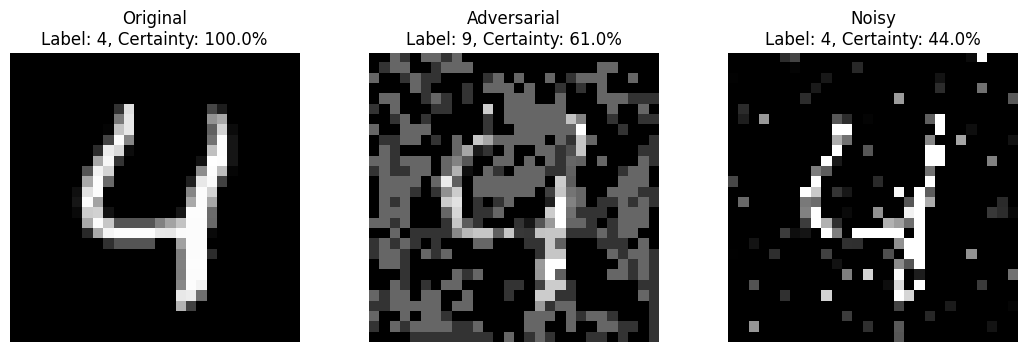

In [4]:
# --- Combined Plot: Original vs Adversarial vs Noisy ---

def plot_comparison(original_img, adversarial_img, noisy_img, model):
    model.eval()
    with torch.no_grad():
        inputs = torch.cat([original_img, adversarial_img, noisy_img])
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        probs = F.softmax(outputs, dim=1)
        certainties = torch.max(probs, dim=1).values * 100

    fig = plt.figure(1, (13., 4.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.7)

    images = [original_img, adversarial_img, noisy_img]
    titles = [
        f"Original\nLabel: {preds[0].item()}, Certainty: {certainties[0]:.1f}%",
        f"Adversarial\nLabel: {preds[1].item()}, Certainty: {certainties[1]:.1f}%",
        f"Noisy\nLabel: {preds[2].item()}, Certainty: {certainties[2]:.1f}%"
    ]

    for i in range(3):
        img = images[i].squeeze().detach().numpy()
        grid[i].imshow(img, cmap='gray')
        grid[i].set_title(titles[i])
        grid[i].axis('off')

    plt.show()

# --- Make sure you have: ---
# 'image'          - the original clean image
# 'image_adv'      - the adversarial image created before
# 'image_noisy'    - the noisy image created with create_noisy_example

# --- Now plot them together ---
plot_comparison(image, image_adv, image_noisy, model)


Adversarial is targeted and clever — small change, but model misclassifies with high certainty.

Noise is random and blind — often hurts model performance, but doesn't "force" wrong label as reliabl